# H Corona sim test

Import the relevant packages:

In [1]:
import numpy as np

In [2]:
%cd /home/mike/Documents/Mars/3D_planetary_RT_model/python
%bookmark corona_model
from py_corona_sim import Pyobservation_fit

/home/mike/Documents/Mars/3D_planetary_RT_model/python


In [3]:
import idl_colorbars

In [4]:
from scipy.spatial.transform import Rotation as R

In [5]:
posdir=np.array([0,-1,0])
posdir=posdir/np.linalg.norm(posdir)
pos=10*3395e5*posdir

right_dir=np.array([1,0,0])
up_dir=np.cross(posdir,right_dir)
up_dir=up_dir/np.linalg.norm(up_dir)
right_dir=-np.cross(posdir,up_dir)
right_dir=right_dir/np.linalg.norm(right_dir)

center_dir=-posdir
angle=60
npix=600
lookangles=np.linspace(-angle*np.pi/180.,angle*np.pi/180.,npix)

In [6]:
def lookdir(az,ax):
    angle1=R.from_rotvec(-az*up_dir).as_matrix()
    angle2=R.from_rotvec(ax*right_dir).as_matrix()
    return np.array([*map(lambda x:np.matmul(x,center_dir),
                          [*map(np.matmul,angle1,angle2)])])


In [7]:
anglepairs=np.array([([ax],[az]) for az in lookangles for ax in lookangles])
all_lookangles=lookdir(anglepairs[:,0],anglepairs[:,1])
all_pos = np.array([pos for i in all_lookangles])

In [8]:
pycorona = Pyobservation_fit()
pycorona.add_observation(all_pos,all_lookangles)
pycorona.set_g_factor([1.22848e-3,2.52e-6])
import time
time.sleep(1)

In [9]:
%time pycorona.generate_source_function(5.5e5,200)
%time brightness = pycorona.brightness()

CPU times: user 503 ms, sys: 147 ms, total: 650 ms
Wall time: 648 ms
CPU times: user 420 ms, sys: 8.55 ms, total: 429 ms
Wall time: 426 ms


In [10]:
absorption = np.exp(-np.where(pycorona.tau_absorber_final() == -1, 1e5, pycorona.tau_absorber_final()))

In [11]:
np.max(absorption*pycorona.tau_species_final(),axis=1)

array([103.62675831,  14.16786671])

In [12]:
brightness.max()

9.875479698181152

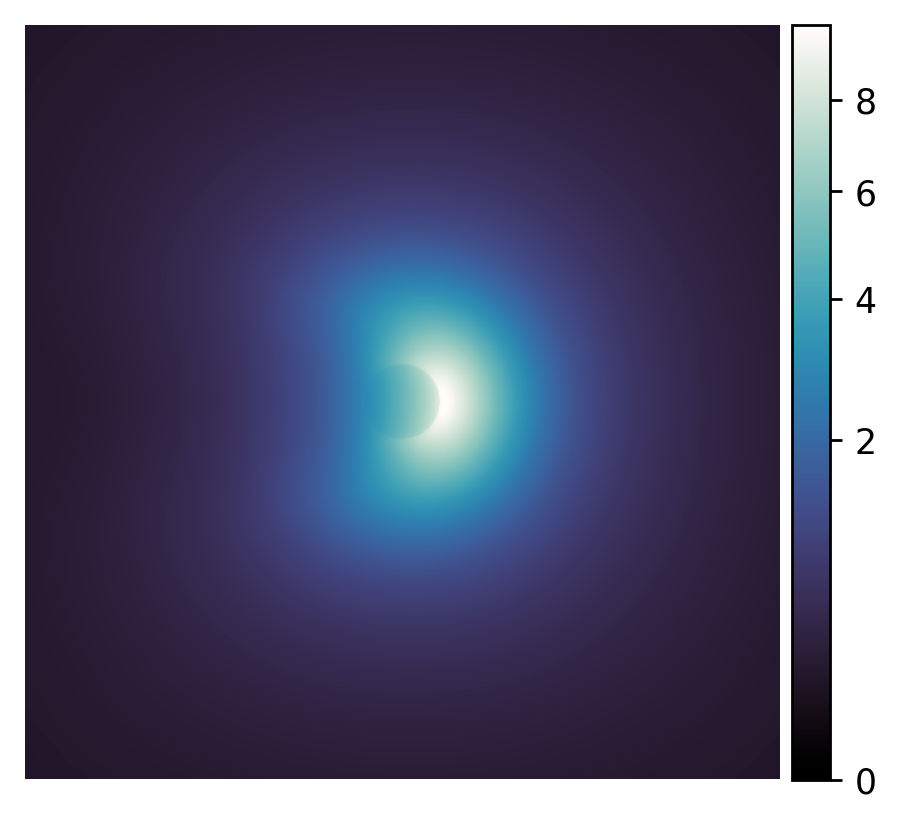

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
from matplotlib.colors import LogNorm,PowerNorm
# C = some matrix
f, ax = plt.subplots(1,dpi=250)

import copy
my_cmap = copy.copy(idl_colorbars.getcmap(109)) # copy the default cmap
my_cmap.set_bad((0,0,0))

im = ax.imshow(brightness[0].reshape((npix,npix)), cmap=my_cmap, norm=PowerNorm(0.5,vmin=0.0, vmax=brightness.max(), clip=True))
t = [0,5,10,15,20]
#im = ax.imshow(brightness.reshape((npix,npix)), cmap=my_cmap, norm=LogNorm(vmin=0.1, vmax=20, clip=True))
#t = [0.1,0.5,1,5,10,20]

ax.set_axis_off()

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(im, cax=cax)#, ticks=t, format='$%.2f$');

This will plot Lyman beta if observation_fit computes it:

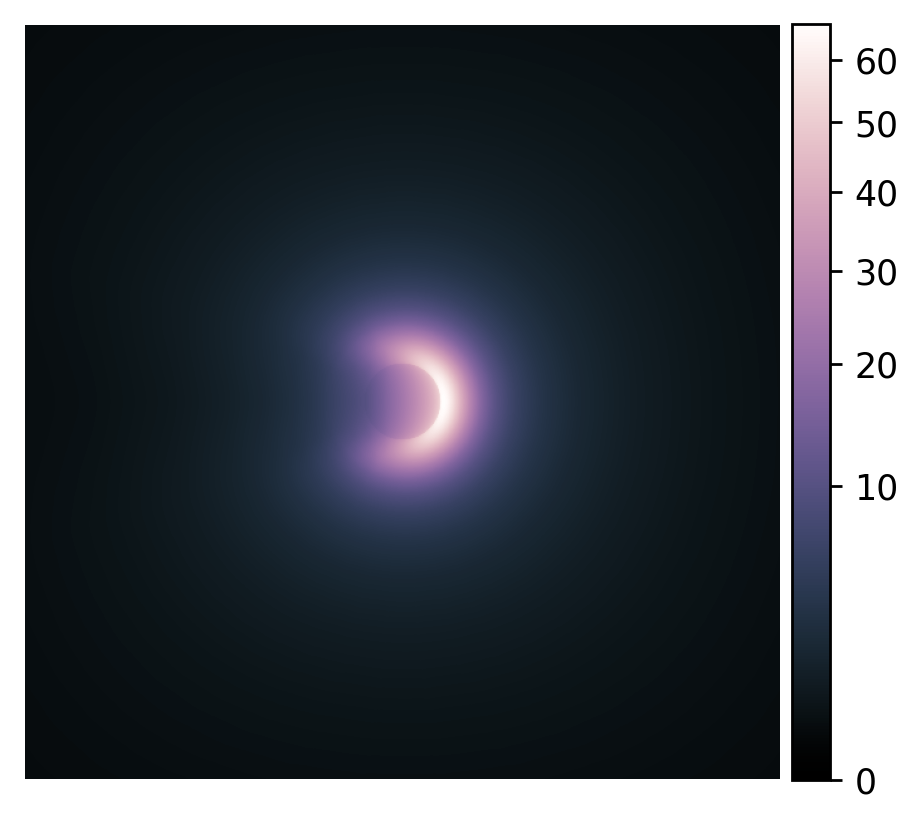

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
from matplotlib.colors import LogNorm,PowerNorm
# C = some matrix
f, ax = plt.subplots(dpi=250)

import copy
my_cmap = copy.copy(idl_colorbars.getcmap(114)) # copy the default cmap
my_cmap.set_bad((0,0,0))

im = ax.imshow(brightness[1].reshape((npix,npix))*1000, cmap=my_cmap, norm=PowerNorm(0.5,vmin=0.0, vmax=1000*brightness[1].max(), clip=True))
#t = [0,50,100]
#im = ax.imshow(brightness.reshape((npix,npix)), cmap=my_cmap, norm=LogNorm(vmin=0.1, vmax=20, clip=True))
#t = [0.1,0.5,1,5,10,20]

ax.set_axis_off()

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(im, cax=cax)#, ticks=t, format='$%.2f$');

# Source Function Inspection

In [15]:
import tempfile

In [16]:
fname = tempfile.NamedTemporaryFile()

In [17]:
fname.name

'/tmp/tmphhmanpfe'

In [18]:
def sfn_readline(line):
    if not ":" in line:
        # this is a potential header, return without stripping
        return [line, []]
    
    name, data = line.split(":")
    return [name, np.fromstring(data.strip(),sep=" ")]

def sfn_dict_append(sfn, file):
    emission_dict_name=None
    variable_dict_name=None
    level_dict_name=None
    subdict=sfn
    
    for line in file:
        name, data = sfn_readline(line)

        # figure out where to place the data on this line

        # figure out the indent level (number of leading spaces / 2)
        indent_level = (len(name) - len(name.lstrip()))/2
        if indent_level==0 and len(data)==0:
            emission_dict_name = name.strip().replace('For ','')
            if emission_dict_name not in sfn.keys():
                sfn[emission_dict_name] = dict()
            emission_dict = sfn[emission_dict_name]
            subdict=emission_dict
            continue
        if indent_level==1:
            # only SZA lives at this level
            continue
        if indent_level==2 and len(data)==0:
            # density, optical depth, etc.
            variable_dict_name = name.strip()
            if variable_dict_name not in sfn[emission_dict_name].keys():
                sfn[emission_dict_name][variable_dict_name] = dict()
            subdict = sfn[emission_dict_name][variable_dict_name]
            continue
        if indent_level==2 and len(data)>0:
            subdict=emission_dict

        name = name.strip()
        if name in subdict.keys():
            if subdict[name].ndim==1:
                subdict[name] = subdict[name][np.newaxis,:]
            subdict[name] = np.append(subdict[name], [data], axis=0)
        else:
            subdict[name] = data

def get_source_function(nH, T):
    fname = tempfile.NamedTemporaryFile()
    pycorona.generate_source_function(nH, T, sourcefn_fname=fname.name)
    sourcefn_file=np.loadtxt(fname.name,dtype=str,delimiter="\n")
    sfn=dict()
    sfn_dict_append(sfn,sourcefn_file)
    return sfn

In [19]:
sfn=get_source_function(5e5, 200)

In [20]:
def plot_H_sourcefn(sfn, x_alt=True):
    fig, ax = plt.subplots(ncols=2,figsize=(9,4),
                           sharex=True,sharey=True,
                           gridspec_kw={'wspace':0.15},
                           dpi=150)
    
    if x_alt:
        alt = 1e-5*(sfn['pts radii [cm]']-3395e5)
        x = [alt, alt, alt]
        ax[0].set_xlim([80,1e5])
        ax[1].set_xlim([80,1e5])
        ax[0].set_xscale('log')
        ax[0].set_xlabel('Altitude [km]')
    else:
        tau0 = [sfn['H Lyman alpha']['Species single scattering tau'][0],
                sfn['H Lyman beta']['Species single scattering tau'][0]]
        x = tau0
        ax[0].set_xscale('log')
        ax[1].set_xscale('log')
        ax[0].set_xlim([1e0,1e-8])
        ax[1].set_xlim([1e1,1e-7])
        ax[0].set_xlabel(r'Line Center $\tau$')
        
    
    cmap = idl_colorbars.getcmap(80,reverse=True)
    
    nsza = len(sfn['pts sza [rad]'])
    for isza in range(nsza):
        ax[0].plot(x[0], sfn['H Lyman alpha']['Source function'][isza], color=cmap(isza/(nsza-1)))
        ax[1].plot(x[1], sfn['H Lyman beta']['Source function'][isza], color=cmap(isza/(nsza-1)))
    
    ax[0].set_title('Lyman alpha')
    ax[1].set_title('Lyman beta')
    
    ax[0].set_ylabel('Upper State Density / Optically Thin Density')

    ax[0].set_ylim([0,2.75])
    
    ax[1].set_ylim([5e-4,10])
    ax[1].set_yscale('log')

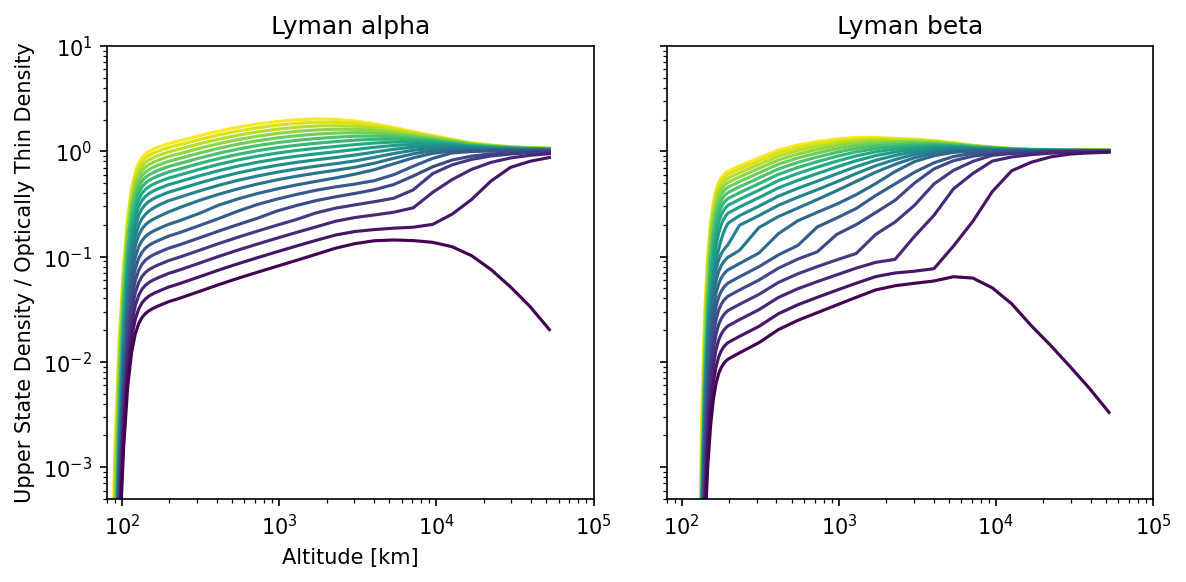

In [22]:
plot_H_sourcefn(sfn)

In [23]:
(sc_mso, fov_mso) = np.load('/home/mike/Documents/EMM/emm_sys015_limb_geom.npy')
sys15_alt = np.load('/home/mike/Documents/EMM/emm_sys015_limb_alt.npy')

In [24]:
pycorona.add_observation(sc_mso,fov_mso)
time.sleep(1)

In [25]:
def get_model_brightness(nH, Texo):
    # get H brightness
    pycorona.generate_source_function(nH,Texo)
    pycorona.set_g_factor([1.22848e-3, 2.05e-6])
    H_brightness = 1000*pycorona.brightness()
    
    lyman_beta_brightness = np.reshape(H_brightness[1], (8,360,128))
    
    return np.mean(lyman_beta_brightness, axis=(0,2))

In [26]:
lyb_brightness = [get_model_brightness(nH,200) for nH in np.logspace(-1,3,num=9,base=2)*1e5]

In [27]:
lyb_brightness = [get_model_brightness(2e5,Texo) for Texo in np.linspace(100,300,9)]

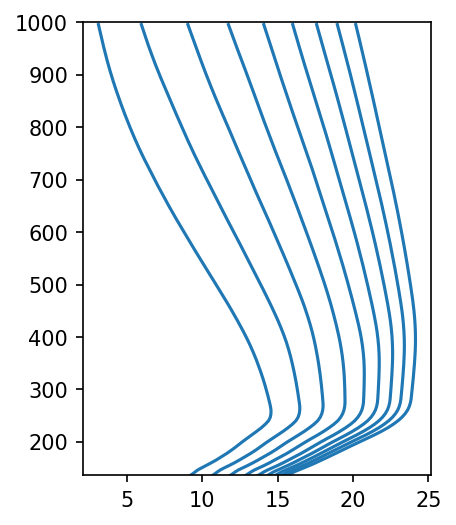

In [28]:
fig, ax = plt.subplots(1, figsize=(3,4), dpi=150)
[ax.plot(b,sys15_alt, color='C0') for b in lyb_brightness]
ax.set_ylim([136,1000]);

In [29]:
sfns = [get_source_function(nH,200) for nH in np.logspace(-1,3,num=9,base=2)*1e5]

(80.0, 500.0)

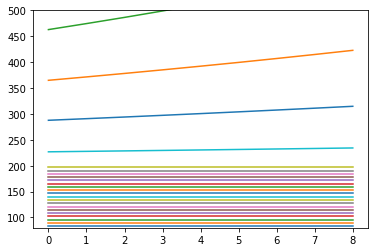

In [30]:
plt.plot([(s['pts radii [cm]']/1e5-3395) for s in sfns]);
plt.ylim([80,500])

(80.0, 200.0)

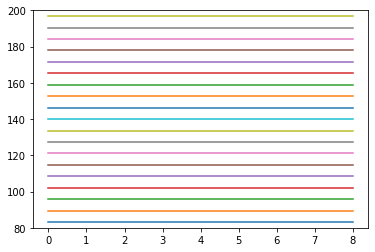

In [31]:
plt.plot([(s['pts radii [cm]']/1e5-3395) for s in sfns]);
plt.ylim([80,200])

# Simulated EMM OS2 geometry

In [32]:
import numpy as np
import spiceypy as spice
import matplotlib.pyplot as plt

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
plt.rcParams['figure.dpi']=300

In [34]:
spice.kclear()
spice.furnsh(['/home/mike/Documents/EMM/science_closure_corona_figure/kernels/de430.bsp',
              '/home/mike/Documents/EMM/science_closure_corona_figure/kernels/naif0011.tls',
              '/home/mike/Documents/EMM/science_closure_corona_figure/kernels/pck00010.tpc',
              '/home/mike/Documents/EMM/science_closure_corona_figure/kernels/mar097.bsp',
              '/home/mike/Documents/EMM/science_closure_corona_figure/kernels/DE403-MASSES.TPC',
              '/home/mike/Documents/MAVEN/IUVS/iuvs-itf-sw/anc/spice/mvn/fk/maven_v09.tf',
              '/home/mike/Documents/EMM/science_closure_corona_figure/kernels/Amal.bsp'])
#now info about EMM orbit is stored in spice body number -200000

In [35]:
#let's pick perihelion for an example image
etstart=spice.str2et('2022 Jun 22')
amalstate=spice.spkezr('-200000',etstart,'MAVEN_MME_2000','NONE','MARS')[0]

In [36]:
marsmu=spice.bodvrd('MARS','GM',1)[1][0]

In [37]:
elements=spice.oscltx(amalstate,etstart,marsmu)
emm_ecc=elements[1]
emm_inc=elements[2]
emm_semimajor_axis=elements[-2]
emm_orbit_period=elements[-1]

In [38]:
#find the location of periapsis
#adapted from the spicepy gfposc tutorial
MAXIVL = 1000
MAXWIN = 2 * MAXIVL
cnfine = spice.stypes.SPICEDOUBLE_CELL(2)
spice.wninsd(etstart,etstart+emm_orbit_period,cnfine)
riswin = spice.stypes.SPICEDOUBLE_CELL( MAXWIN )

In [39]:
spice.gfposc('-200000','MAVEN_MSO','NONE','MARS',
             'LATITUDINAL','RADIUS','ABSMIN',0.0,
             0.0,emm_orbit_period/2, MAXIVL, cnfine, riswin)
emm_peritime=spice.wnfetd(riswin,0)[0]
spice.timout(emm_peritime,'YYYY MON DD HR:MN:SC.### (TDB) ::TDB')

'2022 JUN 23 11:03:52.518 (TDB)'

In [40]:
peri_state=spice.spkezr('-200000',emm_peritime,'MAVEN_MME_2000','NONE','MARS')[0]
peri_elements=spice.oscltx(peri_state,emm_peritime,marsmu)

In [41]:
peri_state_mso=spice.spkezr('-200000',emm_peritime,'MAVEN_MSO','NONE','MARS')[0]
peri_vec=-peri_state_mso[:3]/np.linalg.norm(peri_state_mso[:3])

In [42]:
orbit_subdivisions=1000
etlist=emm_peritime+1.025*emm_orbit_period*np.linspace(0,1,num=orbit_subdivisions)

In [43]:
statelist=spice.spkezr('-200000',etlist,'MAVEN_MSO','NONE','MARS')[0]
sundirection=spice.spkezr('SUN',etlist[0],'MAVEN_MSO','NONE','MARS')[0]

In [44]:
normvecs=[]
for s in statelist:
    c=np.cross(s[:3],s[-3:])
    normvecs.append(c/np.linalg.norm(c))
normal_vec=np.mean(normvecs,axis=0)
cross_vec=np.cross(normal_vec,-peri_vec)

sun_in_orb_vec=sundirection[:3]-np.dot(sundirection[:3],normal_vec)*normal_vec
sun_in_orb_vec=sun_in_orb_vec/np.linalg.norm(sun_in_orb_vec)
sun_cross_vec=np.cross(normal_vec,sun_in_orb_vec)

In [45]:
x_vec=sun_in_orb_vec
y_vec=sun_cross_vec

xyz=[]
stateangles=[]
for s in statelist:
    xyz.append([np.dot(s[:3],x_vec),np.dot(s[:3],y_vec),np.dot(s[:3],normal_vec)])
    orbcoords=xyz[-1][:2]/np.linalg.norm(xyz[-1][:2])
    stateangles.append(np.arctan2(orbcoords[0],orbcoords[1]))
xyz=np.array(xyz)

sunxyz=[np.dot(sundirection[:3],x_vec),np.dot(sundirection[:3],y_vec),np.dot(sundirection[:3],normal_vec)]
sunxyz=sunxyz/np.linalg.norm(sunxyz)

In [46]:
def draw_orbit(ax):
    ax.plot(*(np.transpose(xyz[:,:2])))
    ax.set_aspect('equal')
    rmars=np.mean(spice.bodvrd('MARS','RADII',3)[1])
    mars = plt.Circle((0, 0), rmars, color='#BC2A3A')
    ax.add_artist(mars)

    sunarrowend=(sunxyz[0]*2e4,sunxyz[1]*2e4)
    sunarrowstart=(sunxyz[0]*1.5*rmars,sunxyz[1]*1.5*rmars)
    ax.annotate('',
                xy=sunarrowstart,xytext=sunarrowend,
                arrowprops=dict(facecolor='black',edgecolor='black',width=0,headwidth=5,headlength=5));
    ax.text(2e4,4e3,'Sunlight',ha='right',va='bottom',fontsize=6);

In [47]:
trueanomalylist=[]
for s,t in zip(statelist,etlist):
    trueanomalylist.append(spice.oscltx(s,t,marsmu)[-3])

In [48]:
orbit_plane_angles=[]
for s in statelist:
    p=s[:3]/np.linalg.norm(s[:3])
    x=np.dot(p,-peri_vec)
    y=np.dot(p,cross_vec)
    orbit_plane_angles.append(np.arctan2(y,x))

For some reason the true anomaly reported by spice is not symmetric around the orbit??

In [49]:
#now let's find the values we're interested in
nimgs=6
view_peri_angles=np.linspace(0,2*np.pi,nimgs+1)[:nimgs]

view_peri_angles=[a if a<np.pi else a-2*np.pi for a in view_peri_angles]

view_et=[etlist[(np.abs(orbit_plane_angles-v)).argmin()] for v in view_peri_angles]

In [50]:
view_state=spice.spkezr('-200000',view_et,'MAVEN_MSO','NONE','MARS')[0]
view_state=np.array(view_state)

In [51]:
viewxyz=[]
for s in view_state:
    viewxyz.append([np.dot(s[:3],x_vec),np.dot(s[:3],y_vec),np.dot(s[:3],normal_vec)])
viewxyz=np.array(viewxyz)
view_sun_angles=[np.arctan2(p[1],p[0]) for p in viewxyz]

In [52]:
def lookdir(az,ax,center_dir,right_dir,up_dir):
    angle1=R.from_rotvec(-az*up_dir).as_matrix()
    angle2=R.from_rotvec(ax*right_dir).as_matrix()
    return np.array([*map(lambda x:np.matmul(x,center_dir),
                          [*map(np.matmul,angle1,angle2)])])

In [53]:
def get_obs_vectors(pos,angle=30,npix=600):
    #pos is the spacecraft position in cm
    posdir=pos/np.linalg.norm(pos)

    right_dir=sundirection[:3]/np.linalg.norm(sundirection[:3])
    right_dir=right_dir-np.dot(right_dir,posdir)*posdir
    right_dir=right_dir/np.linalg.norm(right_dir)
    
    up_dir=[0,0,1]
    up_dir=up_dir-np.dot(up_dir,posdir)*posdir-np.dot(right_dir,up_dir)*right_dir
    up_dir=up_dir/np.linalg.norm(up_dir)
    #ensure that the illuminated portion of the atmosphere is to the right, 
    #checking the MSO y-component to see which side of the planet we're on
    if posdir[1]>0:
        up_dir=-up_dir    
    
    #print(np.dot(posdir,right_dir))
    #print(np.dot(posdir,up_dir))
    #print(np.dot(up_dir,right_dir))

    center_dir=-posdir
    lookangles=np.linspace(-angle*np.pi/180.,angle*np.pi/180.,npix)
    
    anglepairs=np.array([([ax],[az]) for az in lookangles for ax in lookangles])
    all_lookangles=lookdir(anglepairs[:,0],anglepairs[:,1],center_dir,right_dir,up_dir)
    all_pos = np.array([pos for i in all_lookangles])
    return (all_pos, all_lookangles)

In [54]:
def fig2rgb_array(fig):
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    return np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

In [55]:
import matplotlib.lines as mlines

def place_obsimage(ax,img,xyorb_loc,xyimg_loc,size=11000,align=(0,0),widthratio=2):
    
    x0=xyimg_loc[0]-widthratio*size*(1-align[0])/2
    x1=xyimg_loc[0]+widthratio*size*(1+align[0])/2
    y0=xyimg_loc[1]-size*(1-align[1])/2
    y1=xyimg_loc[1]+size*(1+align[1])/2
    
    
    l = mlines.Line2D([xyorb_loc[0],xyimg_loc[0]], [xyorb_loc[1],xyimg_loc[1]],zorder=10,lw=0.5)
    ax.add_line(l)
#    print((x0,x1,y0,y1))
    
    ax.imshow(img,extent=(x0,x1,y0,y1),zorder=50)

In [56]:
def place_orbit_images(ax,viewxyz,viewimgs,imgsize=50000,label_emissions=True,widthratio=2):
    posangle=np.mod((np.array(view_peri_angles)+np.pi)+np.pi/6,2*np.pi)-np.pi
    img_pos_idx=[np.abs(posangle-a).argmin() for a in view_sun_angles]
    posdist=[12e4,5.5e4]
    img_pos=np.array([[posdist[0]*np.cos(a),posdist[1]*np.sin(a)] for a in posangle])
    img_pos[1][1]+=2.5e4
    img_pos[-2][1]-=2.5e4
    for idx,(orb_pos,pos_idx) in enumerate(zip(viewxyz,img_pos_idx)):
        place_obsimage(ax,viewimgs[idx],orb_pos[:2],img_pos[pos_idx],size=imgsize,widthratio=widthratio)
    if label_emissions:
        ax.text(-14e4,5.5e4,"Ly "+r"$\beta$")
        ax.text(-9e4,5.5e4,"Ly "+r"$\alpha$")

# O 102.6 nm source function sensitivity studies

In [57]:
pycorona.O_1026_generate_source_function(1e7,200,1.69e-3)

In [58]:
def get_O_1026_brightness(pos,angle=30,npix=300):
    all_pos,all_lookangles=get_obs_vectors(pos,angle=angle,npix=npix)
    pycorona.add_observation(all_pos,all_lookangles)
    return pycorona.O_1026_brightness()

In [59]:
def plot_O_1026_brightness(brightness,dim=None,show=True):
    if dim==None:
        npix=int(np.sqrt(len(brightness[0])))
        dim=(npix,npix)
    
    f, (ax_im) = plt.subplots(ncols=1, figsize=(2,2), dpi=200)
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)

    import copy
    o_1026_cmap = copy.copy(idl_colorbars.getcmap(105)) # copy the default cmap
    o_1026_cmap.set_bad((0,0,0))

    all_lines_brightness = 1000*np.sum(brightness,axis=0)
    
    im = ax_im.imshow(all_lines_brightness.reshape(dim), cmap=o_1026_cmap, norm=PowerNorm(1,vmin=0.0, vmax=40, clip=True))
    ax_im.set_axis_off()
    ax_im.xaxis.set_major_locator(plt.NullLocator())
    ax_im.yaxis.set_major_locator(plt.NullLocator())
   
    f.canvas.draw()
    rgb_array=fig2rgb_array(f)
    
    if show==False:
        plt.close()
    
    return rgb_array

In [60]:
o_1026_brightness_view=[]
for s in view_state:
    o_1026_brightness_view.append(get_O_1026_brightness(s[:3]*1e5,angle=12.5))

In [61]:
np.max(1000*np.sum(o_1026_brightness_view,axis=1))

36.23694619636808

In [62]:
o_1026_viewimgs=[]
for im in o_1026_brightness_view:
    o_1026_viewimgs.append(plot_O_1026_brightness(im,show=False));

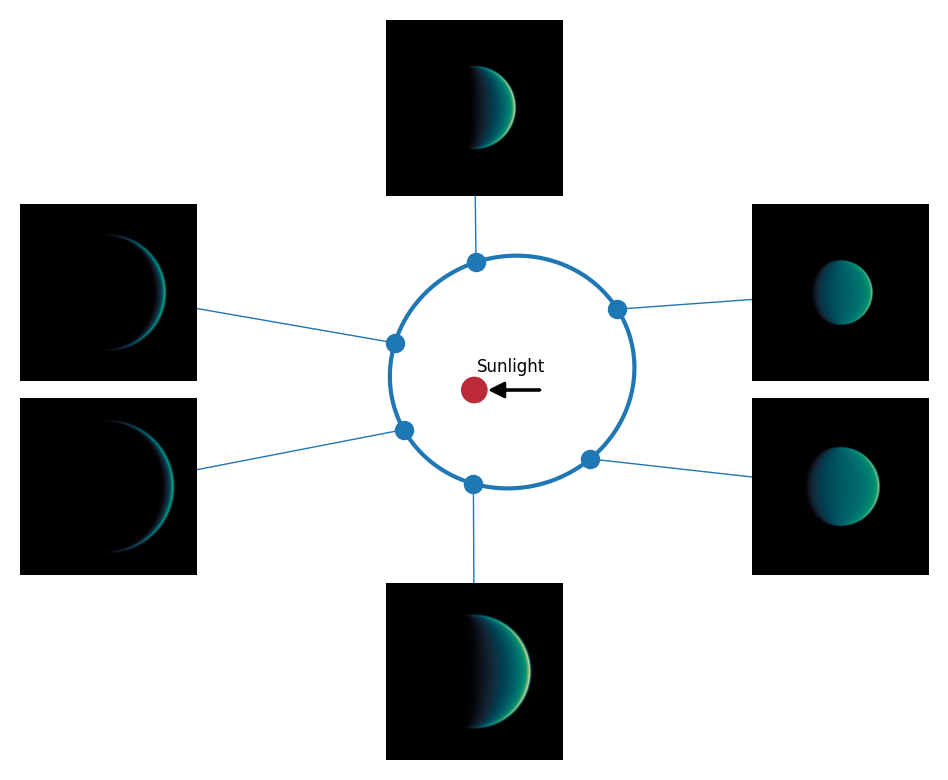

In [63]:
fig, ax_sym = plt.subplots(1,dpi=200,)
fig.patch.set_facecolor('white')

draw_orbit(ax_sym)
ax_sym.scatter(viewxyz[:,0],viewxyz[:,1])

place_orbit_images(ax_sym,viewxyz,o_1026_viewimgs,widthratio=1,label_emissions=False)

ax_sym.autoscale(True)
ax_sym.set_axis_off()

fig.canvas.draw()
plt.tight_layout()

In [64]:
solar_lyman_beta_flux_Hz = 1.69e-3

def get_source_function_O_1026(nO, T):
    fname = tempfile.NamedTemporaryFile()
    pycorona.O_1026_generate_source_function(nO, T, solar_lyman_beta_flux_Hz, sourcefn_fname=fname.name)
    sourcefn_file=np.loadtxt(fname.name,dtype=str,delimiter="\n")
    sfn=dict()
    sfn_dict_append(sfn,sourcefn_file)
    return sfn

In [65]:
O_1026_sfn=get_source_function_O_1026(2e7,200)
O_1026_sfn['O_1026']['Species density [cm-3]']['lower state 2'][0]

array([1.82853e+10, 1.04207e+10, 5.93034e+09, 3.37028e+09, 1.91299e+09,
       1.08458e+09, 6.14342e+08, 3.47845e+08, 1.97048e+08, 1.11827e+08,
       6.36754e+07, 3.64000e+07, 2.08403e+07, 1.19885e+07, 6.87026e+06,
       3.93771e+06, 2.25694e+06, 1.29358e+06, 7.41436e+05, 4.24961e+05,
       2.43570e+05, 1.39607e+05, 8.00169e+04, 4.58621e+04, 2.62865e+04,
       1.50665e+04, 8.63557e+03, 4.94952e+03, 2.83686e+03, 1.62598e+03,
       9.31954e+02, 5.34162e+02, 3.06163e+02, 1.75482e+02, 1.00579e+02,
       5.76477e+01, 3.30413e+01, 1.89380e+01, 1.08535e+01])

In [66]:
def get_O_1026_relative_source_function(O_density, T_exo):
    opt_thin_upper_state_1_fraction = solar_lyman_beta_flux_Hz*2.00e-4*2.647e-2/(1.0697e8)
    opt_thin_upper_state_2_fraction = solar_lyman_beta_flux_Hz*3.01e-3*2.647e-2/(1.0714e8)
    opt_thin_upper_state_3_fraction = solar_lyman_beta_flux_Hz*1.69e-2*2.647e-2/(1.0750e8)
    
    O_1026_sfn = get_source_function_O_1026(O_density, T_exo)
    
    lower_state_2 = O_1026_sfn['O_1026']['Species density [cm-3]']['lower state 2']
    
    opt_thin_upper_state_1 = lower_state_2*opt_thin_upper_state_1_fraction;
    opt_thin_upper_state_2 = lower_state_2*opt_thin_upper_state_2_fraction;
    opt_thin_upper_state_3 = lower_state_2*opt_thin_upper_state_3_fraction;
    
    upper_state_rel_1 = O_1026_sfn['O_1026']['Source function']['upper state 0']/opt_thin_upper_state_1
    upper_state_rel_2 = O_1026_sfn['O_1026']['Source function']['upper state 1']/opt_thin_upper_state_2
    upper_state_rel_3 = O_1026_sfn['O_1026']['Source function']['upper state 2']/opt_thin_upper_state_3
    
    O_1026_sfn['O_1026']['upper state relative densities'] = np.array([upper_state_rel_1,
                                                                       upper_state_rel_2,
                                                                       upper_state_rel_3])
    
    return O_1026_sfn

In [67]:
sfn=get_O_1026_relative_source_function(2e7,200)

In [68]:
sfn['radial boundaries [cm]']

array([3.49500e+08, 3.49892e+08, 3.50298e+08, 3.50724e+08, 3.51178e+08,
       3.51671e+08, 3.52217e+08, 3.52835e+08, 3.53551e+08, 3.54400e+08,
       3.55420e+08, 3.56638e+08, 3.58048e+08, 3.59617e+08, 3.61355e+08,
       3.63109e+08, 3.64881e+08, 3.66670e+08, 3.68477e+08, 3.70301e+08,
       3.72144e+08, 3.74005e+08, 3.75885e+08, 3.77784e+08, 3.79702e+08,
       3.81639e+08, 3.83597e+08, 3.85575e+08, 3.87573e+08, 3.89592e+08,
       3.91632e+08, 3.93694e+08, 3.95777e+08, 3.97883e+08, 4.00011e+08,
       4.02162e+08, 4.04337e+08, 4.06535e+08, 4.08757e+08, 4.11003e+08])

In [69]:
sfn['O_1026']['Temperature [K]'][0]

array([129.595, 132.949, 137.217, 142.397, 148.478, 155.425, 163.142,
       171.41 , 179.784, 187.511, 193.626, 197.468, 199.254, 199.845,
       199.977, 199.998, 200.   , 200.   , 200.   , 200.   , 200.   ,
       200.   , 200.   , 200.   , 200.   , 200.   , 200.   , 200.   ,
       200.   , 200.   , 200.   , 200.   , 200.   , 200.   , 200.   ,
       200.   , 200.   , 200.   , 200.   ])

In [70]:
sfn['O_1026']['Species density [cm-3]']['lower state 2'][0]

array([1.82853e+10, 1.04207e+10, 5.93034e+09, 3.37028e+09, 1.91299e+09,
       1.08458e+09, 6.14342e+08, 3.47845e+08, 1.97048e+08, 1.11827e+08,
       6.36754e+07, 3.64000e+07, 2.08403e+07, 1.19885e+07, 6.87026e+06,
       3.93771e+06, 2.25694e+06, 1.29358e+06, 7.41436e+05, 4.24961e+05,
       2.43570e+05, 1.39607e+05, 8.00169e+04, 4.58621e+04, 2.62865e+04,
       1.50665e+04, 8.63557e+03, 4.94952e+03, 2.83686e+03, 1.62598e+03,
       9.31954e+02, 5.34162e+02, 3.06163e+02, 1.75482e+02, 1.00579e+02,
       5.76477e+01, 3.30413e+01, 1.89380e+01, 1.08535e+01])

In [71]:
sfn['O_1026']['Species single scattering tau']['line 4'][0]

array([1.77383e+02, 1.05844e+02, 6.40079e+01, 3.92973e+01, 2.45242e+01,
       1.55574e+01, 1.00144e+01, 6.51408e+00, 4.25169e+00, 2.75791e+00,
       1.75997e+00, 1.09746e+00, 6.68693e-01, 3.96512e-01, 2.29456e-01,
       1.32807e-01, 7.68735e-02, 4.44983e-02, 2.57594e-02, 1.49124e-02,
       8.63334e-03, 4.99837e-03, 2.89394e-03, 1.67553e-03, 9.70104e-04,
       5.61645e-04, 3.25120e-04, 1.88149e-04, 1.08831e-04, 6.28940e-05,
       3.62878e-05, 2.08773e-05, 1.19512e-05, 6.78037e-06, 3.78493e-06,
       2.04950e-06, 1.04405e-06, 4.61496e-07, 1.23953e-07])

In [72]:
sfn['O_1026']['Species single scattering source function S0']['upper state 2'][0]

array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       3.24212e-25, 3.00283e-17, 6.73016e-13, 1.31003e-10, 1.78975e-09,
       5.99144e-09, 1.04790e-08, 1.45570e-08, 1.79496e-08, 1.84218e-08,
       1.55085e-08, 1.12697e-08, 7.44488e-09, 4.63964e-09, 2.79259e-09,
       1.64685e-09, 9.59663e-10, 5.55343e-10, 3.20073e-10, 1.84046e-10,
       1.05686e-10, 6.06407e-11, 3.47783e-11, 1.99407e-11, 1.14317e-11,
       6.55301e-12, 3.75621e-12, 2.15302e-12, 1.23406e-12, 7.07324e-13,
       4.05412e-13, 2.32367e-13, 1.33184e-13, 7.63284e-14])

In [73]:
sfn['O_1026']['Source function']['upper state 0'][0]

array([-0.00000e+00, -0.00000e+00,  1.15327e-42,  9.27330e-30,
        1.76193e-21,  1.62095e-16,  1.53974e-13,  8.00823e-12,
        1.01648e-10,  6.49259e-10,  1.67422e-09,  2.30150e-09,
        2.18709e-09,  1.67185e-09,  1.10741e-09,  6.80051e-10,
        4.01447e-10,  2.32957e-10,  1.34496e-10,  7.76647e-11,
        4.49538e-11,  2.61226e-11,  1.53067e-11,  9.00138e-12,
        5.17650e-12,  2.92244e-12,  1.60130e-12,  8.49949e-13,
        4.43999e-13,  2.32420e-13,  1.23296e-13,  6.66244e-14,
        3.66658e-14,  2.04766e-14,  1.15535e-14,  6.56191e-15,
        3.74127e-15,  2.13980e-15,  1.22515e-15])

In [74]:
import idl_colorbars

In [75]:
def plot_O_1026_sourcefn(sfn, x_alt=True):
    
    fig, ax = plt.subplots(ncols=3,figsize=(13,4),sharey=True,gridspec_kw={'wspace':0.15})
    
    if x_alt:
        alt = 1e-5*(sfn['pts radii [cm]']-3395e5)
        x = [alt, alt, alt]
        ax[0].set_xlim([100,700])
        ax[1].set_xlim([100,700])
        ax[2].set_xlim([100,700])
        ax[0].set_xlabel('Altitude [km]')
    else:
        tau0 = [sfn['O_1026']['Species single scattering tau']['line 3'][0],
                sfn['O_1026']['Species single scattering tau']['line 4'][0],
                sfn['O_1026']['Species single scattering tau']['line 5'][0]]
        x = tau0
        ax[0].set_xscale('log')
        ax[1].set_xscale('log')
        ax[2].set_xscale('log')
        ax[0].set_xlim([1e0,1e-8])
        ax[1].set_xlim([1e1,1e-7])
        ax[2].set_xlim([1e2,1e-6])
        ax[0].set_xlabel(r'Line Center $\tau$')
        
    
    cmap = idl_colorbars.getcmap(80,reverse=True)
    
    nsza = len(sfn['pts sza [rad]'])
    for isza in range(nsza):
        ax[0].plot(x[0], sfn['O_1026']['upper state relative densities'][0][isza], color=cmap(isza/(nsza-1)))
        ax[1].plot(x[1], sfn['O_1026']['upper state relative densities'][1][isza], color=cmap(isza/(nsza-1)))
        ax[2].plot(x[2], sfn['O_1026']['upper state relative densities'][2][isza], color=cmap(isza/(nsza-1)))
    
    ax[0].set_title('upper state J=1')
    ax[1].set_title('J=2')
    ax[2].set_title('J=3')
    
    ax[0].set_ylabel('Upper State Density / Optically Thin Density')
    

    ax[0].set_ylim([0,2.75])

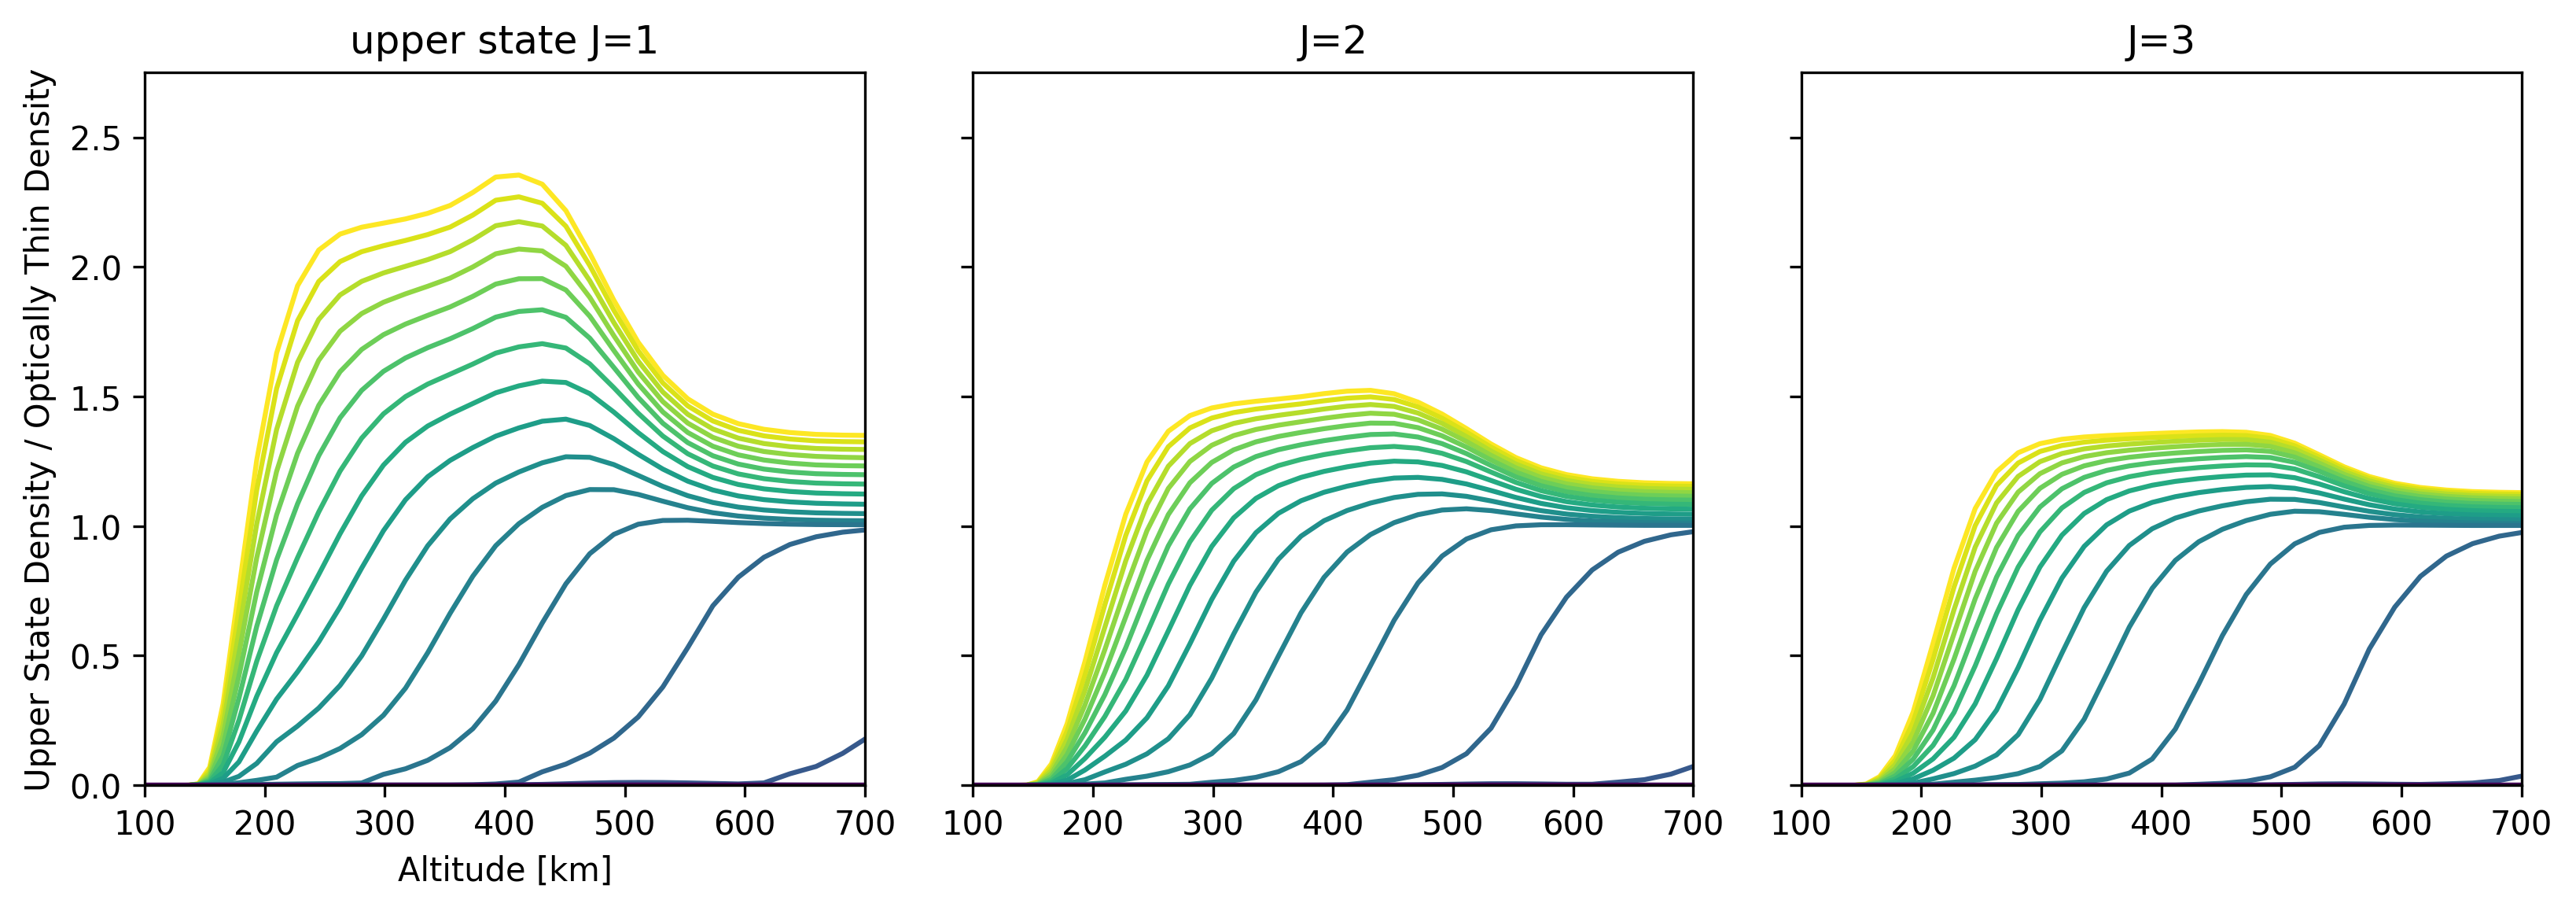

In [76]:
plot_O_1026_sourcefn(sfn, x_alt=True)

In [77]:
def get_O_1026_relative_upper_state_density():
    sfn_reference = get_O_1026_relative_source_function(2e7,200)
    reference_alt = 1e-5*(sfn_reference['pts radii [cm]']-3395e5)
    reference_density = sfn_reference['O_1026']['Source function']['upper state 2'][0]
    
    density_comp_alt = []
    density_comp = []
    for O_density in [0.5e7, 1e7, 4e7, 8e7]:
        sfn=get_O_1026_relative_source_function(O_density,200)
        density_comp_alt.append(1e-5*(sfn['pts radii [cm]']-3395e5))
        density_comp.append(sfn['O_1026']['Source function']['upper state 2'][0])
        
    temp_comp_alt = []
    temp_comp = []
    for O_temp in [100,150,250,300]:
        sfn=get_O_1026_relative_source_function(2e7,O_temp)
        temp_comp_alt.append(1e-5*(sfn['pts radii [cm]']-3395e5))
        temp_comp.append(sfn['O_1026']['Source function']['upper state 2'][0])
        
    return [[reference_alt, reference_density], [density_comp_alt, density_comp], [temp_comp_alt, temp_comp]]

In [78]:
comp_data = get_O_1026_relative_upper_state_density()

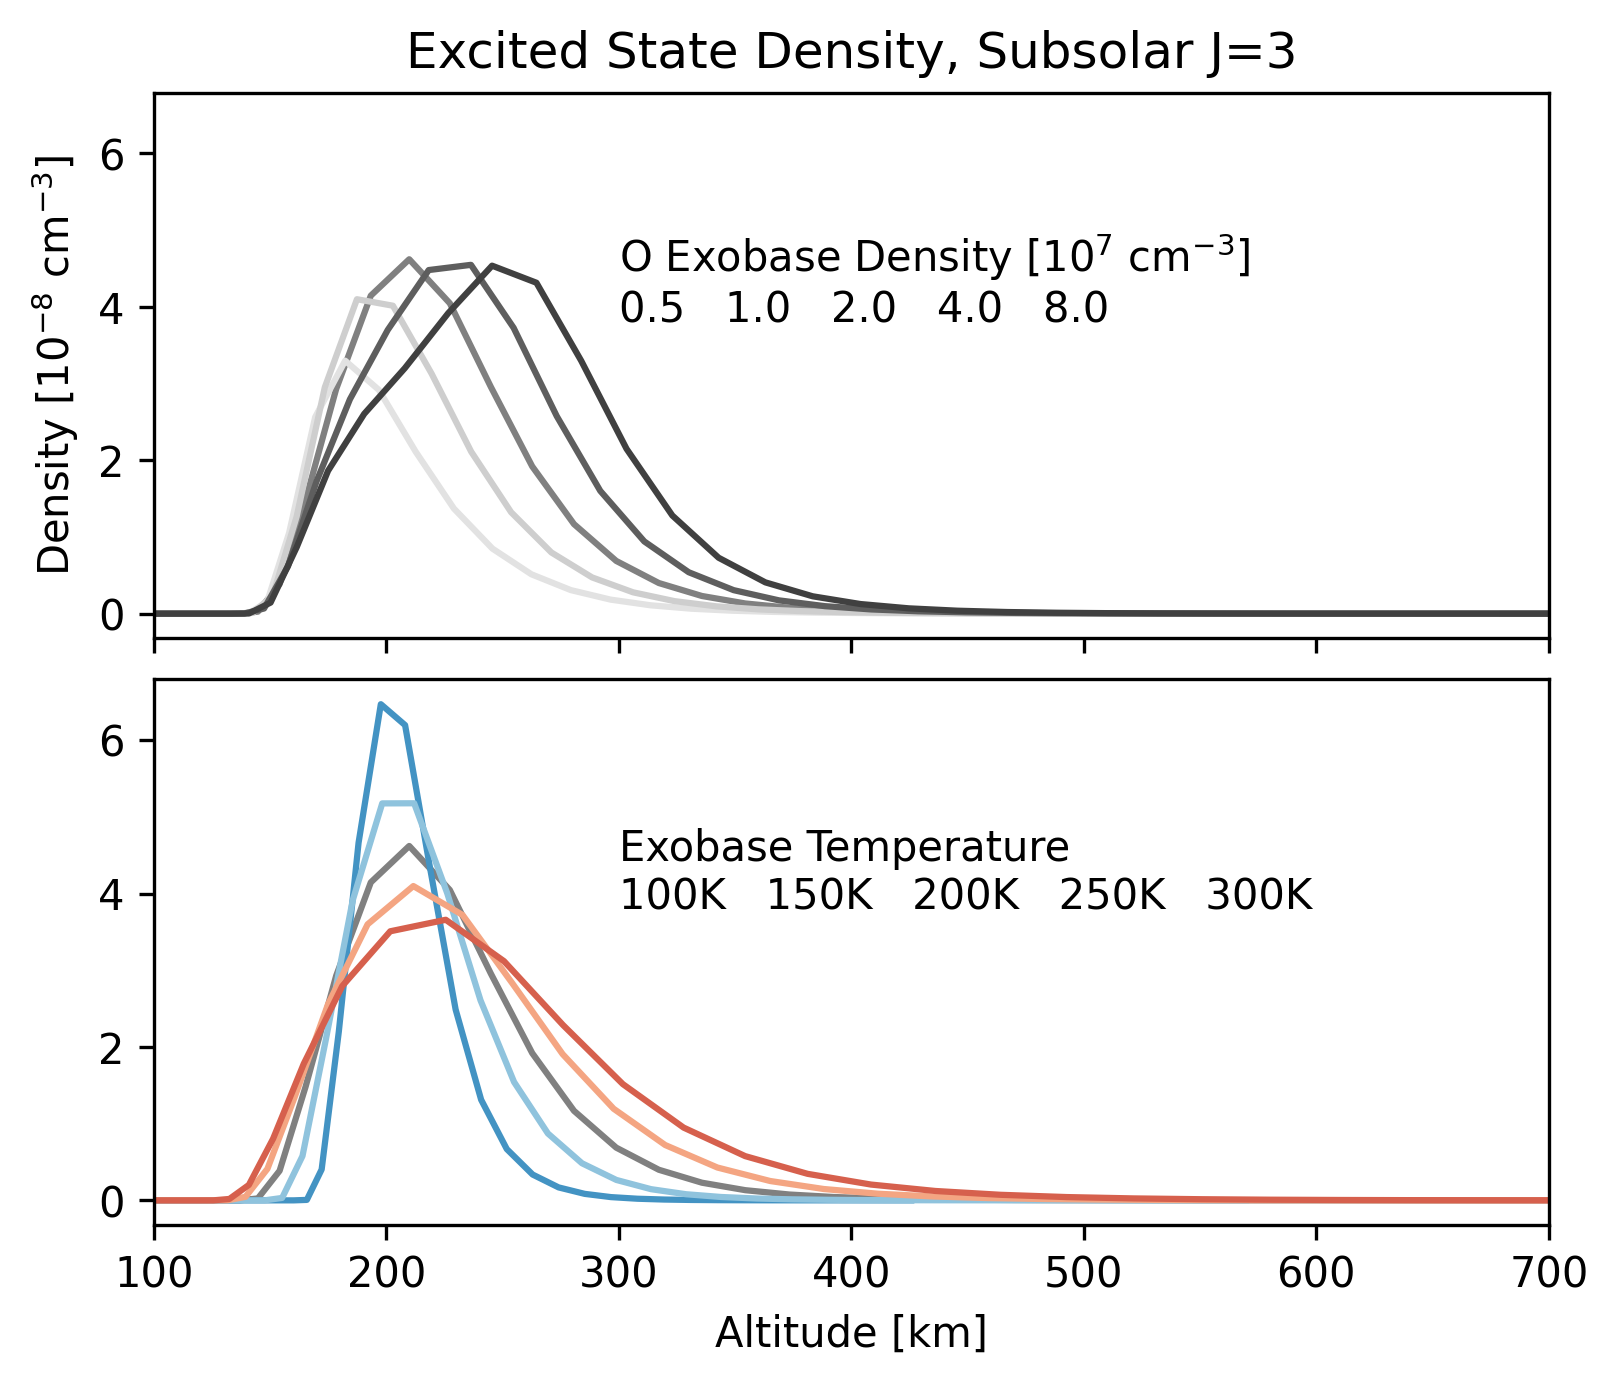

In [79]:
fig, ax = plt.subplots(nrows=2,figsize=(6,5),sharex=True,sharey=True,gridspec_kw={'hspace':0.075})
ax[0].set_xlim([100,700])
ax[0].plot(comp_data[0][0],1e8*comp_data[0][1],color='gray')
ax[1].plot(comp_data[0][0],1e8*comp_data[0][1],color='gray')

ax[0].set_title('Excited State Density, Subsolar J=3')
ax[0].set_ylabel('Density [10$^{-8}$ cm$^{-3}$]')
ax[1].set_xlabel('Altitude [km]')

dens_colors = [idl_colorbars.getcmap(54)(x) for x in [0.2,0.3,0.7,0.8]]
for alt, dens, color in zip(comp_data[1][0],comp_data[1][1], dens_colors):
    ax[0].plot(alt,1e8*dens,color=color)

ax[0].text(x=300,y=3.8,s='O Exobase Density [10$^7$ cm$^{-3}$]\n0.5   1.0   2.0   4.0   8.0')

temp_colors = [idl_colorbars.getcmap(70)(x) for x in [0.8,0.7,0.3,0.2]]
for alt, dens, color in zip(comp_data[2][0],comp_data[2][1], temp_colors):
    ax[1].plot(alt,1e8*dens,color=color)

ax[1].text(x=300,y=3.8,s='Exobase Temperature\n100K   150K   200K   250K   300K');

    
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim([1e-12,1e-7]);